In [113]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [114]:
df = pd.read_csv('seg3.csv')

--- ĐANG XÂY DỰNG BINNING CHO: 3. Mass Unsecured ---
Số lượng mẫu: 283,615
Bad Rate: 19.63%

--- Đang huấn luyện mô hình ML bổ trợ (LightGBM) ---
Running Cross-Validation...
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.862721
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.862048
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.860599
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.861728
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.861615

Đã tạo xong biến 'ML_RISK_BAND'. Phân phối Bad Rate theo nhóm ML:
ML_RISK_BAND
1    0.005113
2    0.044798
3    0.104617
4    0.241

,MAX_DPD_12M_OBS,N_AVG_DEPOSIT_12M,CBAL_TO_INC_12MON,RATE_AVG,INCOME,ML_RISK_BAND,BAD_NEXT_12M
0,3.569568,0.522490,-0.043613,-0.080290,0.003264,3.861109,0
1,-2.230712,-0.182758,-0.134534,-0.197164,0.003264,-1.756321,0
2,0.664989,0.086413,-0.043613,-0.174133,-0.021963,0.737129,0
3,-1.492198,0.522490,-0.218327,-0.269930,0.020393,-1.756321,1
4,-0.980120,0.396718,-0.003670,0.007247,0.003264,-0.264153,0



=== KIỂM TRA ĐA CỘNG TUYẾN ===


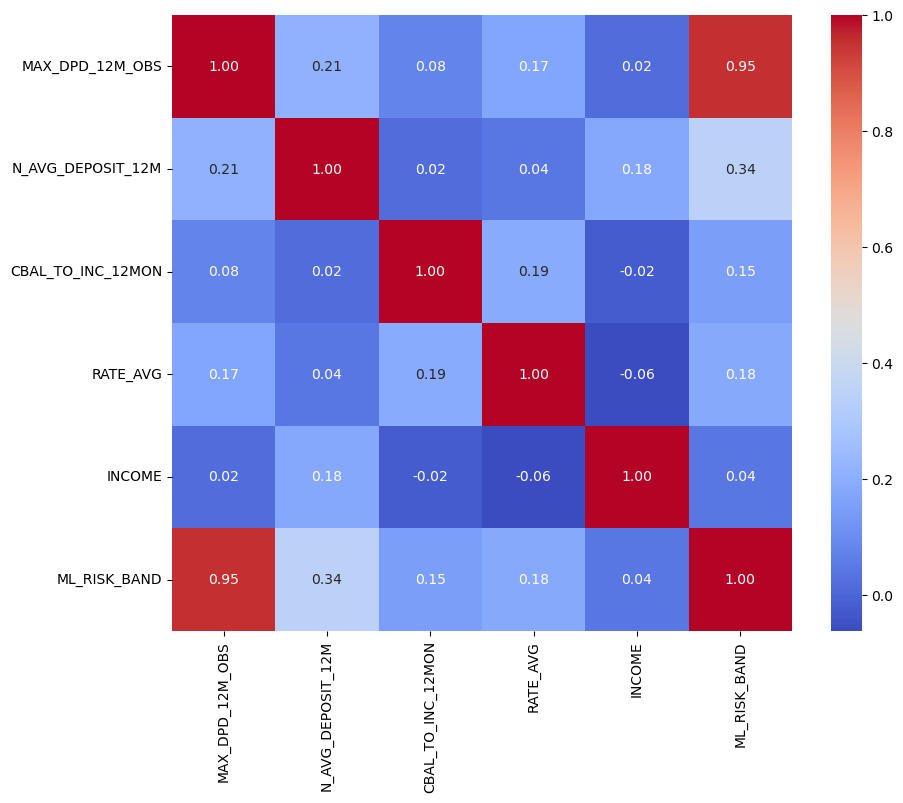


=== HUẤN LUYỆN MÔ HÌNH SCORECARD ===
Optimization terminated successfully.
         Current function value: 0.346151
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           BAD_NEXT_12M   No. Observations:               283615
Model:                          Logit   Df Residuals:                   283608
Method:                           MLE   Df Model:                            6
Date:                Wed, 07 Jan 2026   Pseudo R-squ.:                  0.3010
Time:                        15:18:39   Log-Likelihood:                -98174.
converged:                       True   LL-Null:                   -1.4044e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.4238      0.006   -229.183      

In [115]:
# ==========================================
# 14. WOE BINNING CHO PHÂN KHÚC "MASS UNSECURED"
# ==========================================
from optbinning import OptimalBinning
import matplotlib.pyplot as plt

# 1. Lọc dữ liệu cho phân khúc Mass
target_segment = '3. Mass Unsecured'
df_model = df[
    (df['SEGMENT'] == target_segment) & 
    (df['SAMPLE_TYPE'] == 'TRAIN') 
].copy()

X_model = df_model.drop(columns=['BAD_NEXT_12M', 'SEGMENT', 'SAMPLE_TYPE', 'SOCIF', 'year'])
y_model = df_model['BAD_NEXT_12M']

print(f"--- ĐANG XÂY DỰNG BINNING CHO: {target_segment} ---")
print(f"Số lượng mẫu: {len(df_model):,}")
print(f"Bad Rate: {y_model.mean():.2%}")

# 2. Chọn danh sách biến cần Binning (Lấy Top IV từ bước trước)
selected_features = [
    'MAX_DPD_12M_OBS', 'N_AVG_DEPOSIT_12M', 'CBAL_TO_INC_12MON', 'RATE_AVG', 'INCOME'
]

# --- QUAN TRỌNG: KHỞI TẠO FINAL FEATURES ---
final_features = selected_features.copy()
# -------------------------------------------

# ==========================================
# [NEW STRATEGY] HYBRID STACKING: ML AS A FEATURE
# Sử dụng LightGBM làm "Chuyên gia tư vấn" cho Logistic Regression
# ==========================================
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import numpy as np

print("\n--- Đang huấn luyện mô hình ML bổ trợ (LightGBM) ---")

# 1. Chuẩn bị dữ liệu cho ML (Dùng các biến thô quan trọng)
# Thêm LTV và N_AVG_OVERDUE vào để ML "săn" tín hiệu kỹ hơn
ml_features = ['MAX_DPD_12M_OBS', 'N_AVG_DEPOSIT_12M', 'CBAL_TO_INC_12MON', 
               'RATE_AVG', 'INCOME', 'LTV', 'N_AVG_OVERDUE_CBAL_12M']

X_ml = X_model[ml_features].copy()
y_ml = y_model.copy()

# 2. Huấn luyện LightGBM (Dùng Cross-Validation 5-Fold)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ml_preds = np.zeros(len(X_ml))

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 100,
    'learning_rate': 0.05,
    'max_depth': 3,       # Giữ mô hình đơn giản
    'min_child_samples': 50,
    'verbose': -1,
    'seed': 42
}

print("Running Cross-Validation...")
for train_idx, val_idx in skf.split(X_ml, y_ml):
    X_tr, X_val = X_ml.iloc[train_idx], X_ml.iloc[val_idx]
    y_tr, y_val = y_ml.iloc[train_idx], y_ml.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    # Huấn luyện
    gbm = lgb.train(params, lgb_train, valid_sets=[lgb_eval], 
                    callbacks=[lgb.early_stopping(10), lgb.log_evaluation(0)])
    
    # Dự báo OOF
    ml_preds[val_idx] = gbm.predict(X_val, num_iteration=gbm.best_iteration)

# 3. Biến đổi điểm ML thành biến phân loại (Binning 5 nhóm)
X_model['ML_RISK_SCORE'] = ml_preds
# Chia thành 5 nhóm (Quintiles)
X_model['ML_RISK_BAND'] = pd.qcut(X_model['ML_RISK_SCORE'], q=5, labels=False, duplicates='drop') + 1
X_model['ML_RISK_BAND'] = X_model['ML_RISK_BAND'].astype(int)

print("\nĐã tạo xong biến 'ML_RISK_BAND'. Phân phối Bad Rate theo nhóm ML:")
print(y_model.groupby(X_model['ML_RISK_BAND']).mean())

# 4. Cập nhật vào danh sách biến cho LogReg
if 'ML_RISK_BAND' not in final_features:
    final_features.append('ML_RISK_BAND')

print(f"\nDanh sách biến cuối cùng ({len(final_features)} biến): {final_features}")

# ==========================================
# 15. TRANSFORMATION: CHUYỂN ĐỔI DỮ LIỆU SANG WOE
# ==========================================
print("\n=== CHUYỂN ĐỔI DỮ LIỆU GỐC SANG DẠNG WOE ===")

# Tạo DataFrame mới để chứa giá trị WOE
X_woe = pd.DataFrame()
woe_models = {} 

for feature in final_features:
    print(f"Transforming: {feature}...")
    
    # Cấu hình Binning
    # Lưu ý: Với biến ML_RISK_BAND, ta ép nó phải đơn điệu tăng (monotonic_trend="ascending")
    # vì Band càng cao -> Rủi ro càng cao (do logic qcut ở trên)
    curr_trend = "ascending" if feature == 'ML_RISK_BAND' else "auto_asc_desc"
    
    optb = OptimalBinning(name=feature, dtype="numerical", solver="mip",
                          monotonic_trend=curr_trend)
    
    optb.fit(X_model[feature], y_model)
    
    # Lưu kết quả
    X_woe[feature] = optb.transform(X_model[feature], metric="woe")
    woe_models[feature] = optb

# Thêm cột Target
X_woe['BAD_NEXT_12M'] = y_model.values

print("-" * 30)
print("Dữ liệu sau khi chuyển đổi WOE (5 dòng đầu):")
display(X_woe.head())

# ==========================================
# 16. KIỂM TRA TƯƠNG QUAN
# ==========================================
import seaborn as sns

print("\n=== KIỂM TRA ĐA CỘNG TUYẾN ===")
corr = X_woe.drop(columns=['BAD_NEXT_12M']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

# ==========================================
# 17. HUẤN LUYỆN LOGISTIC REGRESSION
# ==========================================
import statsmodels.api as sm

print("\n=== HUẤN LUYỆN MÔ HÌNH SCORECARD ===")

# Loại bỏ biến LTV nếu nó tồn tại (để tránh nhiễu nếu ML đã bắt LTV rồi)
final_features_clean = [col for col in final_features if col != 'LTV']

X_train = X_woe[final_features_clean].reset_index(drop=True)
y_train = y_model.reset_index(drop=True)
X_train_const = sm.add_constant(X_train)

try:
    logit_model = sm.Logit(y_train, X_train_const)
    result = logit_model.fit()
    print(result.summary())
except Exception as e:
    print(f"Lỗi: {str(e)}")
# ==========================================
# 18. KIỂM TRA P-VALUE (SIGNIFICANCE)
# ==========================================
if 'result' in locals():
    print("\n--- ĐÁNH GIÁ CÁC BIẾN (P-VALUE CHECK) ---")
    p_values = result.pvalues
    
    # Lọc các biến có P-value cao (không có ý nghĩa thống kê)
    # Thường ngưỡng là 0.05
    high_p_value_vars = p_values[p_values >= 0.05]
    
    if len(high_p_value_vars) > 0:
        print("\nCẢNH BÁO: Các biến sau có P-value cao (cần xem xét loại bỏ):")
        print(high_p_value_vars)
    else:
        print("\nTUYỆT VỜI: Tất cả các biến đều có ý nghĩa thống kê (P < 0.05)!")

In [116]:
# ==========================================
# 19. CHẠY LẠI MÔ HÌNH (FINAL MODEL) & ĐÁNH GIÁ GINI
# ==========================================
from sklearn.metrics import roc_auc_score

print("\n=== HUẤN LUYỆN MÔ HÌNH LẦN 2 (SAU KHI LOẠI BIẾN YẾU) ===")

# 1. Chốt danh sách biến cuối cùng (Chỉ giữ lại biến P < 0.05)
# Bỏ 'INCOME' và 'RATE_AVG' 
final_vars_v2 = ['MAX_DPD_12M_OBS', 
    'N_AVG_DEPOSIT_12M', 
    'CBAL_TO_INC_12MON', 'ML_RISK_BAND', 'INCOME']

print(f"Biến đưa vào mô hình: {final_vars_v2}")

# 2. Chuẩn bị dữ liệu (Reset index để tránh lỗi)
X_train_v2 = X_woe[final_vars_v2].reset_index(drop=True)
y_train_v2 = y_model.reset_index(drop=True)

X_train_const_v2 = sm.add_constant(X_train_v2)

# 3. Fit mô hình
logit_final = sm.Logit(y_train_v2, X_train_const_v2)
result_final = logit_final.fit()

print(result_final.summary())

# ==========================================
# 20. TÍNH GINI & KẾT LUẬN SỨC MẠNH MÔ HÌNH
# ==========================================
print("\n--- ĐÁNH GIÁ SỨC MẠNH MÔ HÌNH (PERFORMANCE) ---")

# Dự báo xác suất (Probability) trên tập Train
y_pred_prob = result_final.predict(X_train_const_v2)

# Tính AUC
auc = roc_auc_score(y_train_v2, y_pred_prob)

# Tính Gini (Công thức: Gini = 2*AUC - 1)
gini = 2 * auc - 1

print(f"-> AUC Score: {auc:.4f}")
print(f"-> GINI Coefficient: {gini:.4f}")

if gini > 0.4:
    print("=> ĐÁNH GIÁ: Mô hình TUYỆT VỜI (Excellent).")
elif gini > 0.3:
    print("=> ĐÁNH GIÁ: Mô hình TỐT (Good).")
else:
    print("=> ĐÁNH GIÁ: Mô hình TRUNG BÌNH/YẾU.")


=== HUẤN LUYỆN MÔ HÌNH LẦN 2 (SAU KHI LOẠI BIẾN YẾU) ===
Biến đưa vào mô hình: ['MAX_DPD_12M_OBS', 'N_AVG_DEPOSIT_12M', 'CBAL_TO_INC_12MON', 'ML_RISK_BAND', 'INCOME']
Optimization terminated successfully.
         Current function value: 0.346152
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           BAD_NEXT_12M   No. Observations:               283615
Model:                          Logit   Df Residuals:                   283609
Method:                           MLE   Df Model:                            5
Date:                Wed, 07 Jan 2026   Pseudo R-squ.:                  0.3010
Time:                        15:18:40   Log-Likelihood:                -98174.
converged:                       True   LL-Null:                   -1.4044e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
------------

In [117]:
# ==========================================
# 21. ĐÁNH GIÁ MÔ HÌNH TRÊN TẬP OOS VÀ OOT (VALIDATION)
# ==========================================
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score

print("\n=== KẾT QUẢ ĐÁNH GIÁ TOÀN DIỆN (TRAIN - OOS - OOT) ===")

# Danh sách các tập dữ liệu cần đánh giá
datasets = ['TRAIN', 'OOS', 'OOT']
metrics_summary = []

for sample_type in datasets:
    # 1. Lọc dữ liệu theo đúng Sample Type
    df_val = df[
        (df['SEGMENT'] == target_segment) & 
        (df['SAMPLE_TYPE'] == sample_type)
    ].copy()
    
    if len(df_val) == 0:
        print(f"⚠️ Không có dữ liệu cho tập {sample_type}")
        continue

    # 2. Chuyển đổi WOE (Dùng lại model đã học từ tập Train)
    # Lưu ý: woe_models đã được lưu ở Bước 15
    X_val_woe = pd.DataFrame()
    
    for feature in final_vars_v2:
        # Lấy "luật" binning đã học từ trước
        if feature in woe_models:
            binning_model = woe_models[feature]
            # Chỉ Transform, KHÔNG Fit lại
            X_val_woe[feature] = binning_model.transform(df_val[feature], metric="woe")
        else:
            print(f"❌ Lỗi: Không tìm thấy model binning cho biến {feature}")

    # 3. Chuẩn bị dữ liệu chạy mô hình
    # Reset index để tránh lệch dòng
    y_val = df_val['BAD_NEXT_12M'].reset_index(drop=True)
    X_val = X_val_woe.reset_index(drop=True)
    
    # Thêm hằng số (Intercept) giống hệt lúc Train
    X_val_const = sm.add_constant(X_val)

    # 4. Dự báo (Predict)
    # Dùng result_final đã train xong để chấm điểm
    y_pred_prob = result_final.predict(X_val_const)

    # 5. Tính Gini
    auc = roc_auc_score(y_val, y_pred_prob)
    gini = 2 * auc - 1
    
    # Lưu kết quả
    metrics_summary.append({
        'Sample': sample_type,
        'Observations': len(df_val),
        'Bad Rate': y_val.mean(),
        'AUC': auc,
        'GINI': gini
    })

# ==========================================
# 22. HIỂN THỊ BẢNG SO SÁNH
# ==========================================
results_df = pd.DataFrame(metrics_summary)
# Định dạng hiển thị % cho đẹp
results_df['Bad Rate'] = results_df['Bad Rate'].map('{:.2%}'.format)
results_df['AUC'] = results_df['AUC'].map('{:.2%}'.format)
results_df['GINI'] = results_df['GINI'].map('{:.2%}'.format)

print("-" * 60)
print(results_df)
print("-" * 60)

# Đánh giá độ ổn định
gini_train = float(results_df[results_df['Sample']=='TRAIN']['GINI'].values[0].strip('%')) / 100
gini_oot = float(results_df[results_df['Sample']=='OOT']['GINI'].values[0].strip('%')) / 100

diff = gini_train - gini_oot

print(f"\nĐỘ CHÊNH LỆCH (TRAIN - OOT): {diff:.2%}")
if abs(diff) > 0.20:
    print("=> CẢNH BÁO: MÔ HÌNH KHÔNG ỔN ĐỊNH (Chênh lệch Train/OOT quá lớn).")

# 2. Trường hợp Train cao hơn OOT nhiều -> Overfitting (Học vẹt)
elif diff > 0.10:
    print("=> CẢNH BÁO: MÔ HÌNH CÓ DẤU HIỆU OVERFITTING.")

# 3. Trường hợp OOT cao hơn Train một chút (Số âm nhỏ) -> Tốt (Reverse Vintage)
elif diff < 0:
    print("=> TỐT: Hiệu suất trên tập OOT còn tốt hơn tập Train (Reverse Vintage).")

# 4. Trường hợp còn lại (Chênh lệch dương nhỏ < 10%) -> Ổn định
else:
    print("=> MÔ HÌNH RẤT ỔN ĐỊNH (Stable).")


=== KẾT QUẢ ĐÁNH GIÁ TOÀN DIỆN (TRAIN - OOS - OOT) ===


KeyError: 'ML_RISK_BAND'

In [ ]:
# ==========================================
# 23. CALIBRATION: CHUYỂN ĐỔI PD SANG ĐIỂM SỐ (SCORING)
# ==========================================
import numpy as np

print("\n=== BƯỚC 1: TÍNH ĐIỂM (CALIBRATION) ===")

# 1. Cấu hình tham số Scaling (Theo chuẩn thị trường)
pdo = 20           # Points to Double Odds (Tăng 20 điểm thì tỷ lệ Good/Bad tăng gấp đôi)
base_score = 600   # Điểm cơ sở
base_odds = 50     # Tại điểm 600, tỷ lệ Good/Bad là 50:1

# 2. Tính Factor và Offset
factor = pdo / np.log(2)
offset = base_score - (factor * np.log(base_odds))

print(f"Tham số Scaling: PDO={pdo}, Base Score={base_score}, Base Odds={base_odds}")
print(f"-> Factor: {factor:.4f}")
print(f"-> Offset: {offset:.4f}")

# 3. Tính toán Score cho toàn bộ dữ liệu (Train + OOS + OOT)
# Lưu ý: Mô hình Logistic trả về Logit (y = ax + b). 
# Công thức: Score = Offset - (Factor * Logit) 
# (Dấu trừ vì Logit càng cao -> PD càng cao -> Điểm phải càng thấp)

# Lấy lại Logit (Decision function)
# Ta cần tính lại logit cho toàn bộ DataFrame 'df' ban đầu
# Trước hết, transform toàn bộ df sang WOE
X_all_woe = pd.DataFrame()
for feature in final_vars_v2:
    if feature in woe_models:
        X_all_woe[feature] = woe_models[feature].transform(df[feature], metric="woe")

X_all_const = sm.add_constant(X_all_woe)
df['LOGIT'] = result_final.predict(X_all_const, transform=False) # Lấy logit thô
df['PREDICT_PROB'] = result_final.predict(X_all_const)           # Lấy xác suất PD

# Tính điểm
df['SCORE'] = offset - (factor * df['LOGIT'])
df['SCORE'] = df['SCORE'].round().astype(int) # Làm tròn điểm

print("\nXem mẫu 5 khách hàng với điểm số:")
print(df[['SOCIF', 'LOGIT', 'PREDICT_PROB', 'SCORE', 'BAD_NEXT_12M']].head())

# ==========================================
# 24. XÂY DỰNG THANG XẾP HẠNG (MASTER SCALE)
# ==========================================
from optbinning import OptimalBinning

print("\n=== BƯỚC 2: PHÂN HẠNG TỐI ƯU (OPTIMAL BINNING) ===")

# Mục tiêu: Chia Score thành các khoảng (Bins) sao cho:
# 1. Tối đa hóa IV (Sự khác biệt rủi ro giữa các hạng)
# 2. Đơn điệu (Hạng cao thì Bad Rate thấp)
# 3. Đảm bảo tỷ trọng tối thiểu (Concentration)

# Lấy dữ liệu Train để xây dựng thang điểm (Không dùng OOT để xây thang)
df_scale_train = df[df['SAMPLE_TYPE'] == 'TRAIN'].copy()

# Cấu hình Optbinning cho biến SCORE
# monotonic_trend="descending": Điểm càng cao -> Bad Rate càng thấp (Xu hướng giảm dần)
optb_score = OptimalBinning(
    name="SCORE",
    dtype="numerical",
    solver="cp",                # Constraint programming (Tối ưu nhất)
    monotonic_trend="descending", 
    max_n_bins=10,              # Yêu cầu 10 hạng
    min_prebin_size=0.05        # Mỗi hạng tối thiểu 5% dân số (Tránh tập trung quá mức)
)

optb_score.fit(df_scale_train['SCORE'], df_scale_train['BAD_NEXT_12M'])

# Hiển thị bảng cắt điểm
score_table = optb_score.binning_table.build()
print("\nBảng phân chia các khoảng điểm (Cut-offs):")
display(score_table)

# ==========================================
# 25. GÁN NHÃN XẾP HẠNG (MAPPING)
# ==========================================
print("\n=== BƯỚC 3: GÁN NHÃN HẠNG (AAA -> B) ===")

# Tạo danh sách nhãn chuẩn (10 hạng)
# Lưu ý: Optbinning trả về thứ tự Bin 0, 1, 2... 
# Vì trend="descending" (Điểm thấp -> Bad Rate cao), nên Bin 0 là nhóm rủi ro nhất (Điểm thấp nhất).
# Tuy nhiên, ta cần map ngược lại: Điểm cao nhất là AAA.

# Lấy các điểm cắt (Splits)
splits = optb_score.splits
print(f"Các điểm cắt (Cut-off points): {splits}")

def assign_rating(score):
    # Logic gán hạng dựa trên điểm cắt của Optbinning
    # Giả sử splits = [450, 480, 510...]
    # Ta phải hard-code hoặc loop qua splits.
    # Để linh hoạt, ta dùng chính binning transform
    return optb_score.transform([score], metric="indices")[0]

# Áp dụng phân Bin cho toàn bộ dữ liệu
df['RATING_INDEX'] = optb_score.transform(df['SCORE'], metric="indices")

# Map Index sang Tên Hạng (Rating Label)
# Bin cuối cùng (Index lớn nhất) là Điểm cao nhất -> AAA
# Bin đầu tiên (Index 0) là Điểm thấp nhất -> B hoặc C
num_bins = df['RATING_INDEX'].max() + 1
rating_labels = [
    'B', 'BB', 'BB+', 'BBB', 'BBB+', 'A', 'A+', 'AA', 'AA+', 'AAA'
]

# Nếu số bin ít hơn 10 (do thuật toán gộp), ta cắt list label tương ứng
# Đảm bảo label xịn nhất luôn ở cuối
if num_bins < 10:
    print(f"⚠️ Lưu ý: Thuật toán chỉ tìm thấy {num_bins} nhóm tối ưu (thay vì 10).")
    # Lấy các label quan trọng nhất
    current_labels = rating_labels[-num_bins:] 
else:
    current_labels = rating_labels

# Tạo từ điển mapping: Index -> Label
rating_map = {i: label for i, label in enumerate(current_labels)}

df['RATING'] = df['RATING_INDEX'].map(rating_map)

print("Phân phối hạng trên toàn bộ danh mục:")
print(df['RATING'].value_counts().sort_index())

# ==========================================
# 26. KIỂM ĐỊNH THANG ĐIỂM (VALIDATION & HHI)
# ==========================================
print("\n=== BƯỚC 4: KIỂM ĐỊNH THANG XẾP HẠNG ===")

# Tính toán bảng thống kê theo Hạng
def calculate_rating_performance(df_in):
    stats = df_in.groupby('RATING').agg({
        'SOCIF': 'count',
        'BAD_NEXT_12M': 'sum',
        'SCORE': ['min', 'max', 'mean'],
        'PREDICT_PROB': 'mean'
    }).reset_index()
    
    # Làm phẳng MultiIndex
    stats.columns = ['Rating', 'Count', 'Bad_Count', 'Min_Score', 'Max_Score', 'Mean_Score', 'Avg_PD']
    
    # Tính các chỉ số
    total_obs = stats['Count'].sum()
    stats['Percent_Pop'] = stats['Count'] / total_obs
    stats['Bad_Rate'] = stats['Bad_Count'] / stats['Count']
    
    # Sắp xếp theo mức độ rủi ro (Avg_PD giảm dần hoặc Min_Score tăng dần)
    stats = stats.sort_values(by='Min_Score', ascending=True).reset_index(drop=True)
    
    return stats

rating_perf = calculate_rating_performance(df)

# --- 1. Tính HHI (Độ tập trung) ---
# HHI = Tổng bình phương tỷ trọng (%)
# HHI dao động từ 0 đến 1. Dưới 0.25 là tốt (không bị dồn cục vào 1 hạng).
hhi_index = (rating_perf['Percent_Pop'] ** 2).sum()

print("\nBẢNG HIỆU SUẤT THANG XẾP HẠNG:")
display(rating_perf[['Rating', 'Min_Score', 'Max_Score', 'Count', 'Percent_Pop', 'Bad_Rate', 'Avg_PD']])

print("-" * 50)
print(f"CHỈ SỐ TẬP TRUNG HHI: {hhi_index:.4f}")

if hhi_index < 0.20:
    print("=> ĐÁNH GIÁ: Tốt. Phân phối đều, không bị tập trung quá mức.")
elif hhi_index < 0.30:
    print("=> ĐÁNH GIÁ: Chấp nhận được.")
else:
    print("=> CẢNH BÁO: Tập trung cao tại một số hạng. Cần chỉnh min_prebin_size.")

# --- 2. Kiểm tra tính đơn điệu (Monotonicity) ---
# Bad Rate phải giảm dần từ hạng thấp (B) lên hạng cao (AAA)
is_monotonic = rating_perf['Bad_Rate'].is_monotonic_decreasing
print(f"TÍNH ĐƠN ĐIỆU CỦA BAD RATE: {'✅ ĐẠT' if is_monotonic else '❌ KHÔNG ĐẠT'}")

# --- 3. Vẽ biểu đồ trực quan ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Vẽ cột tỷ trọng (Population)
ax1 = sns.barplot(x='Rating', y='Percent_Pop', data=rating_perf, color='skyblue', alpha=0.7, label='% Dân số')
ax1.set_ylabel('Tỷ trọng KH (%)')
ax1.set_title('Phân phối Hạng và Tỷ lệ nợ xấu (Calibration Plot)')

# Vẽ đường Bad Rate
ax2 = ax1.twinx()
sns.lineplot(x='Rating', y='Bad_Rate', data=rating_perf, marker='o', color='red', linewidth=2, sort=False, ax=ax2, label='Bad Rate')
ax2.set_ylabel('Tỷ lệ nợ xấu thực tế (%)')

# Thêm nhãn giá trị
for i, p in enumerate(ax1.patches):
    ax1.annotate(f"{p.get_height():.1%}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom', fontsize=9, color='blue')

plt.show()